# Bayesian Seizure Likelihood Estimation

In [60]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
import pandas as pd
from tqdm import tqdm

from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay, brier_score_loss, roc_auc_score, average_precision_score
from sklearn.utils.estimator_checks import check_estimator

from msc import config
from msc.cache_handler import get_samples_df
from msc.estimators import BSLE
from msc.plot_utils import set_size
from msc.time_utils import SEC, MIN, HOUR
from msc.data_utils import EvalData

plt.style.use(["science", "no-latex"])

fig_width = 478  # pt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [61]:
# plt.rcParams.keys()

In [1]:
# Helper function used for visualization in the following examples
def identify_axes(ax_dict, fontsize=48):
    """
    Helper to identify the Axes in the examples below.

    Draws the label in a large font in the center of the Axes.

    Parameters
    ----------
    ax_dict : dict[str, Axes]
        Mapping between the title / label and the Axes.
    fontsize : int, optional
        How big the label should be.
    """
    kw = dict(ha="center", va="center", fontsize=fontsize, color="darkgrey")
    for k, ax in ax_dict.items():
        ax.text(0.5, 0.5, k, transform=ax.transAxes, **kw)
        

## Load data

In [62]:
dataset_id = str(config["dataset_id"])
t_max = config["t_max"]

# load samples_df
samples_df = get_samples_df(dataset_id, with_events=True, with_time_to_event=True)

# split train/test
samples_df["set"] = samples_df["time"].apply(
    lambda t: "train" if t < t_max else "test"
)

# add is_event
samples_df["is_event"] = samples_df["time_to_event"].apply(
    lambda x: True if x == 0 else False
)

# define horizon
horizon = 0  # detection
# horizon = 5 * SEC
# horizon = 30 * MIN  # prediction

## AUC-ROC Grid

* A : unsupervised heatmap
* B : weakly supervised heatmapÉ 
* C : AUC-ROCS for specific horizon, both heatmaps
* D : Roc curve at specific point on left heatmap
* E : ROC curve at specific point on right heatmap

In [63]:

def get_roc_auc_scores_for_thresholds(eval_data, thresholds):
    unsupervised_scores = []
    weakly_supervised_scores = []
    for threshold in thresholds:
        bsle = BSLE(thresh=threshold)
        # unsupervised fit
        bsle.fit(eval_data.train_X)
        pred_y = bsle.predict(eval_data.test_X)
        score = roc_auc_score(eval_data.test_y, pred_y)
        unsupervised_scores.append(score)
        # weakly supervised fit
        bsle.fit(eval_data.train_X, y=None, prior_events=eval_data.train_events)
        pred_y = bsle.predict_proba(eval_data.test_X, samples_times=eval_data.test_times)
        score = roc_auc_score(eval_data.test_y, pred_y)
        weakly_supervised_scores.append(score)
    return unsupervised_scores, weakly_supervised_scores


def auc_roc_scores_for_thresholds_and_horizons(samples_df, time_scale, axes=None):
    if time_scale == "sec":
        horizons = np.arange(0, 65, 5) * SEC
    elif time_scale == "min":
        horizons = np.arange(0, 65, 5) * MIN
    else:
        raise ValueError("time_scale must be either SEC or MIN")
    thresholds = np.linspace(0, 0.2, 21, endpoint=True)
    unsupervised_score_rows = []
    weakly_supervised_score_rows = []
    for horizon in horizons:
        samples_df["class"] = samples_df["time_to_event"].apply(
        lambda x: 1 if x <= horizon else 0
        )
        
        # get training event times
        train_events = samples_df.loc[
            (samples_df["is_event"]) & (samples_df["set"] == "train"), "time"
        ].to_numpy()

        # train/test data
        train_X = np.stack(samples_df.loc[samples_df["set"] == "train", "embedding"])  # type: ignore
        test_X = np.stack(samples_df.loc[samples_df["set"] == "test", "embedding"])  # type: ignore
        test_y = samples_df.loc[samples_df["set"] == "test", "class"].to_numpy()
        test_times = samples_df.loc[samples_df["set"] == "test", "time"].to_numpy()

        eval_data = EvalData(train_X, train_events, test_X, test_times, test_y)

        unsupervised_scores, weakly_supervised_scores = get_roc_auc_scores_for_thresholds(eval_data, thresholds)
        unsupervised_score_rows.append(unsupervised_scores)
        weakly_supervised_score_rows.append(weakly_supervised_scores)
    unsupervised_scores = np.stack(unsupervised_score_rows).T
    weakly_supervised_scores = np.stack(weakly_supervised_score_rows).T
    row_labels = [f"{t:.2f}" for t in thresholds]
    col_labels = [f"{int(h/MIN)}" for h in horizons] if time_scale == "min" else [f"{int(h/SEC)}" for h in horizons]

    # set up subplot axes
    if axes is None:
        fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=set_size(fig_width))
    else:
        fig = plt.gcf()
    im = axes[0].imshow(unsupervised_scores, cmap="RdBu", vmin=0, vmax=1)
    axes[0].set_title("Unsupervised")
    axes[0].set_xticks(np.arange(unsupervised_scores.shape[1]), labels=col_labels)
    axes[0].set_yticks(np.arange(unsupervised_scores.shape[0]), labels=row_labels)
    axes[0].set_xlabel(f"Horizon ({time_scale})")
    axes[0].set_ylabel("Threshold")

    im = axes[1].imshow(weakly_supervised_scores, cmap="RdBu", vmin=0, vmax=1)
    axes[1].set_title("Weakly Supervised")
    axes[1].set_xticks(np.arange(unsupervised_scores.shape[1]), labels=col_labels)
    axes[1].set_yticks(np.arange(unsupervised_scores.shape[0]), labels=row_labels)
    axes[1].set_xlabel(f"Horizon ({time_scale})")
    axes[1].set_ylabel("Threshold")
    # create colorbar
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.ax.set_ylabel("ROC AUC", rotation=-90, va="bottom")

    # rotate the xtick labels
    plt.setp(axes[0].get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")
    plt.setp(axes[1].get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")
#     plt.savefig(
#         f"{config['path']['figures']}/bsle/auc_roc_scores_for_thresholds_and_horizons_{time_scale}.pdf",
#         bbox_inches="tight",
#     )
    

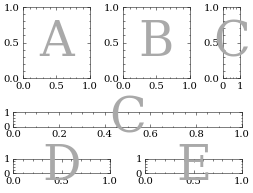

In [70]:
# prepare data
# horizons = np.arange(0, 65, 5) * SEC - 10  #shift horizon for correct label
# thresholds = np.linspace(0, 0.2, 21, endpoint=True)
# unsupervised_score_rows = []
# weakly_supervised_score_rows = []
# for horizon in horizons:
#     samples_df["class"] = samples_df["time_to_event"].apply(
#     lambda x: 1 if x <= horizon else 0
#     )

#     # get training event times
#     train_events = samples_df.loc[
#         (samples_df["is_event"]) & (samples_df["set"] == "train"), "time"
#     ].to_numpy()

#     # train/test data
#     train_X = np.stack(samples_df.loc[samples_df["set"] == "train", "embedding"])  # type: ignore
#     test_X = np.stack(samples_df.loc[samples_df["set"] == "test", "embedding"])  # type: ignore
#     test_y = samples_df.loc[samples_df["set"] == "test", "class"].to_numpy()
#     test_times = samples_df.loc[samples_df["set"] == "test", "time"].to_numpy()

#     eval_data = EvalData(train_X, train_events, test_X, test_times, test_y)

#     unsupervised_scores, weakly_supervised_scores = get_roc_auc_scores_for_thresholds(eval_data, thresholds)
#     unsupervised_score_rows.append(unsupervised_scores)
#     weakly_supervised_score_rows.append(weakly_supervised_scores)
# unsupervised_scores = np.stack(unsupervised_score_rows).T
# weakly_supervised_scores = np.stack(weakly_supervised_score_rows).T
# row_labels = [f"{t:.2f}" for t in thresholds]
# col_labels = [f"{int(h/MIN)}" for h in horizons] if time_scale == "min" else [f"{int(h/SEC)}" for h in horizons]



# prepare axes
mosaic_top = """ABC"""
mosaic_bottom = """CC
                    DE"""
fig = plt.figure(constrained_layout=True)
top, bottom = fig.subfigures(nrows=2, ncols=1)
ax_top = top.subplot_mosaic(mosaic_top,
                        gridspec_kw={"width_ratios": [4, 4, 1]})
identify_axes(ax_top)

ax_bottom = bottom.subplot_mosaic(mosaic_bottom)
identify_axes(ax_bottom)

# plot
# ax = ax_top['A']
# im = ax.imshow(unsupervised_scores, cmap="RdBu", vmin=0, vmax=1)
# ax.set_title("Unsupervised")
# ax.set_xticks(np.arange(unsupervised_scores.shape[1]), labels=col_labels)
# ax.set_yticks(np.arange(unsupervised_scores.shape[0]), labels=row_labels)
# ax.set_xlabel(f"Horizon ({time_scale})")
# ax.set_ylabel("Threshold")

Forward-simulation of circular Gaussian distribution

## Empirical events - subject_id

## Plot the inference of the empirical data

## Sampling the Cox Process

## Inferring the Latent Intensity Function

## Checking the Model